In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import beacon
from tqdm import tqdm
from torchinfo import summary

F:\projects\ResearchProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [3]:
def draw_parabola(canvas, origin=None):
    if origin is None:
        origin_x = np.random.randint(0, canvas.shape[1])
        origin_y = np.random.randint(canvas.shape[0]*0.25, canvas.shape[0])
    else:
        origin_x = origin[0]
        origin_y = origin[1]

    theta = np.arange(0, 1*np.pi, 0.0001)

    min_side = np.minimum(canvas.shape[1], canvas.shape[0])
    radius = np.random.randint(min_side, min_side*3)
    x = origin_x + radius * np.cos(theta)
    y = (origin_y - radius + 1) + radius * np.sin(theta)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)

    valid_indices = np.where((x >= 0) & (x < canvas.shape[1]) & (y >= 0) & (y < canvas.shape[0]))

    x_parabola_coords = x[valid_indices]
    y_parabola_coords = y[valid_indices]
    canvas[y_parabola_coords, x_parabola_coords] = 1

    point_r = (x_parabola_coords[0], y_parabola_coords[0])
    point_l = (x_parabola_coords[-1], y_parabola_coords[-1])

    return point_r, point_l


def draw_line(canvas, start, angle, max_lit_px=400):
    angle = np.radians(angle)

    dx = np.cos(angle)
    dy = np.sin(angle)

    x, y = start
    lit_pixels = 0

    while lit_pixels < max_lit_px:
        x_rounded = int(round(x))
        y_rounded = int(round(y))

        if 0 <= x_rounded < canvas.shape[1] and 0 <= y_rounded < canvas.shape[0]:
            canvas[y_rounded, x_rounded] = 1

        if lit_pixels != 0:
            if x_rounded <= 0:
                dx = abs(dx)
            elif x_rounded >= canvas.shape[1] - 1:
                dx = -abs(dx)

        x += dx
        y -= dy
        lit_pixels += 1


def random_remove_points(canvas, n_remove):
    none_zero_indices = canvas.nonzero()
    if none_zero_indices.shape[0] < n_remove:
        return

    if n_remove >= 1:
        random_indices = np.random.choice(none_zero_indices.shape[0], n_remove, replace=False)
    else:
        n = int(n_remove * none_zero_indices.shape[0])
        random_indices = np.random.choice(none_zero_indices.shape[0], n, replace=False)

    for i in random_indices:
        x = none_zero_indices[i][1]
        y = none_zero_indices[i][0]
        canvas[y, x] = 0



def set_continuous_time(canvas, t_start):
    rows, cols = canvas.shape
    canvas = canvas.clone()

    first_row = 0
    time_end = 0

    for row in range(rows-1, -1, -1):
        non_zero_indices = np.where(canvas[row, :] != 0)[0]
        if non_zero_indices.size > 0:
            if first_row is None:
                first_row = row
            time_index = rows - row + t_start
            canvas[row, non_zero_indices] = time_index
            time_end = time_index

    return canvas, time_end


def set_random_time(canvas, t_start, t_end):
    canvas = canvas.clone()

    random_times = torch.randint(t_start, t_end, canvas.shape, dtype=canvas.dtype, device=canvas.device)

    canvas[canvas != 0] = random_times[canvas != 0]

    return canvas


def generate_binary_noise(*dim, p=0.001, magnitude=1):
    random_tensor = torch.rand(*dim)
    return (random_tensor < p).float() * magnitude

def generate_noise(data, p=0.001):
    return torch.clamp(generate_binary_noise(data.shape, p=p, magnitude=1) - data, 0, 1)


def plot3d(data, ax=None):
    if ax is None:
        ax = plt.figure().add_subplot(projection='3d')
    data_np = data.numpy().squeeze()
    y, x = np.nonzero(data_np)
    time_values = data_np[y, x]
    ax.scatter(y, x, time_values, c=time_values)
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_zlabel('Time')
    ax.set_box_aspect(None, zoom=0.85)

def plot2d(data):
    plt.imshow(data.squeeze())
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()

In [35]:
class TorchData:
    def __init__(self, t_dim, x_dim, y_dim, n_remove=10, noise_p=0.1, time_mode='random'):
        """
        Initiate torch datasets.
        Args:
            t_dim: int, time dimension
            x_dim: int, x dimension
            y_dim: int, y dimension
            n_remove: int, number of points to remove
        """
        self.t_dim = t_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_remove = n_remove
        self.signal = torch.zeros(self.x_dim, self.y_dim)
        self.noise = torch.zeros(self.x_dim, self.y_dim)
        self.sn = torch.zeros(self.x_dim, self.y_dim)
        self.signal_time = torch.zeros(self.x_dim, self.y_dim)
        self.noise_time = torch.zeros(self.x_dim, self.y_dim)
        self.sn_time = torch.zeros(self.x_dim, self.y_dim)
        self.generate(noise_p, time_mode)

    def generate(self, noise_p, time_mode):
        """
        Generate datasets.
        """
        pr, pl = draw_parabola(self.signal)

        angle = np.random.randint(10, 40)
        draw_line(self.signal, pr, angle)
        draw_line(self.signal, pl, angle)
        random_remove_points(self.signal, self.n_remove)

        self.signal_time, time_end = set_continuous_time(self.signal, 100)
        self.noise = generate_noise(self.signal, p=noise_p)

        if time_mode == 'random':
            self.noise_time = set_random_time(self.noise, 100, time_end+10)
        elif time_mode == 'continuous':
            self.noise_time, _ = set_continuous_time(self.noise, 100)

        self.sn_time = self.signal_time + self.noise_time


In [27]:
import torch.nn.functional as F
def calculate_mse_torch(original, denoised):
    mse = torch.mean((original - denoised) ** 2)
    return mse.item()

def calculate_psnr_torch(original, denoised):
    mse = calculate_mse_torch(original, denoised)
    if mse == 0:
        return float('inf')  # No noise in the image, PSNR is infinite.
    max_pixel = torch.max(original)
    psnr = 10 * torch.log10((max_pixel ** 2) / mse)
    return psnr.item()

def calculate_ssim_torch(original, denoised, window_size=11):
    if original.ndim == 2:
        original = original.unsqueeze(0).unsqueeze(0)
    if denoised.ndim == 2:
        denoised = denoised.unsqueeze(0).unsqueeze(0)

    def gaussian_window(window_size, sigma):
        gauss = torch.tensor(
            [-(x - window_size // 2) ** 2 / float(2 * sigma ** 2) for x in range(window_size)],
            dtype=torch.float32
        )
        gauss = torch.exp(gauss)
        gauss = gauss / gauss.sum()
        return gauss.reshape(1, 1, 1, -1).repeat(1, 1, window_size, 1)

    window = gaussian_window(window_size, 1.5).to(original.device)
    padding = window_size // 2

    mu1 = F.conv2d(original, window, padding=padding, groups=1)
    mu2 = F.conv2d(denoised, window, padding=padding, groups=1)

    sigma1_sq = F.conv2d(original * original, window, padding=padding, groups=1) - mu1 ** 2
    sigma2_sq = F.conv2d(denoised * denoised, window, padding=padding, groups=1) - mu2 ** 2
    sigma12 = F.conv2d(original * denoised, window, padding=padding, groups=1) - mu1 * mu2

    max_val = torch.max(original)
    C1 = (0.01 * max_val) ** 2
    C2 = (0.03 * max_val) ** 2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_map = torch.clamp(ssim_map, min=0.0, max=1.0)  # Ensure SSIM stays in [0, 1]

    return ssim_map.mean().item()


In [28]:
train_dataset = np.array([TorchData(100, 120, 92, 50) for _ in range(300)])
test_dataset = np.array([TorchData(100, 120, 92, 50) for _ in range(1)])

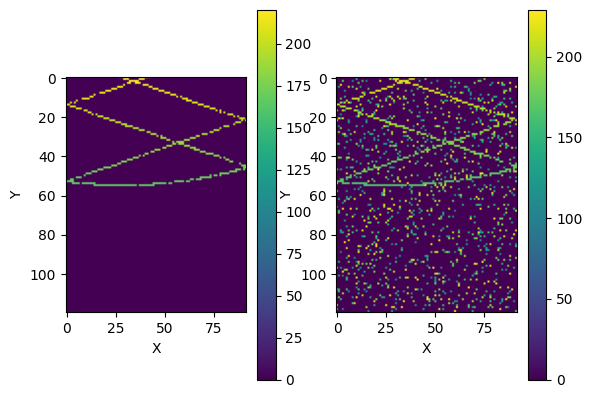

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot2d(train_dataset[0].signal_time)
ax2 = fig.add_subplot(122)
plot2d(train_dataset[0].sn_time)

In [36]:
r_data = TorchData(100, 120, 92, 50, noise_p=0.01, time_mode='random')
c_data = TorchData(100, 120, 92, 50, noise_p=0.01, time_mode='continuous')

Text(0.5, 0.92, 'signal and noise')

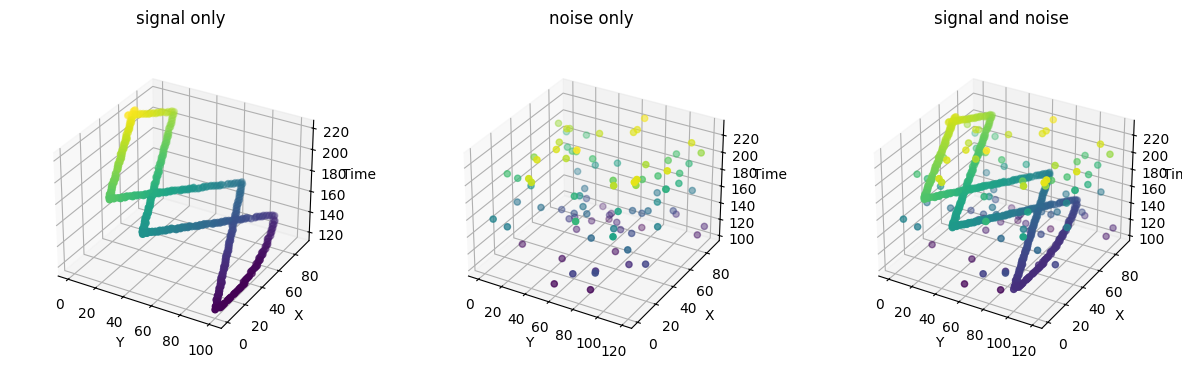

In [42]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(r_data.signal_time, ax1)
ax1.set_title('signal only')
ax2 = fig.add_subplot(132, projection='3d')
plot3d(r_data.noise_time, ax2)
ax2.set_title('noise only')
ax3 = fig.add_subplot(133, projection='3d')
plot3d(r_data.sn_time, ax3)
ax3.set_title('signal and noise')

Text(0.5, 0.92, 'continuous time dimension')

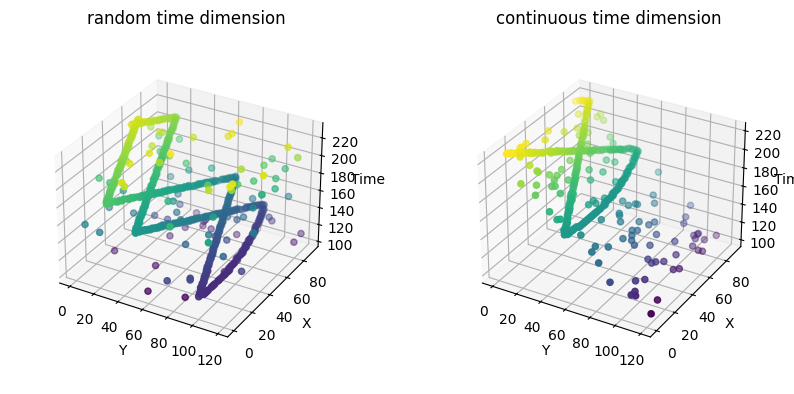

In [38]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
plot3d(r_data.sn_time, ax1)
ax1.set_title('random time dimension')
ax2 = fig.add_subplot(122, projection='3d')
plot3d(c_data.sn_time, ax2)
ax2.set_title('continuous time dimension')

In [8]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(2, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 2, 3, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
summary(ConvolutionAutoencoder(), input_size=(300, 2, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [300, 2, 120, 92]         --
├─Sequential: 1-1                        [300, 8, 114, 86]         --
│    └─Conv2d: 2-1                       [300, 64, 118, 90]        1,216
│    └─BatchNorm2d: 2-2                  [300, 64, 118, 90]        128
│    └─ReLU: 2-3                         [300, 64, 118, 90]        --
│    └─Conv2d: 2-4                       [300, 16, 116, 88]        9,232
│    └─BatchNorm2d: 2-5                  [300, 16, 116, 88]        32
│    └─ReLU: 2-6                         [300, 16, 116, 88]        --
│    └─Conv2d: 2-7                       [300, 8, 114, 86]         1,160
│    └─BatchNorm2d: 2-8                  [300, 8, 114, 86]         16
│    └─ReLU: 2-9                         [300, 8, 114, 86]         --
├─Sequential: 1-2                        [300, 2, 120, 92]         --
│    └─BatchNorm2d: 2-10                 [300, 8, 114, 86]         16
│    

In [10]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [11]:
a = np.array([_.sn for _ in train_dataset])
b = np.array([_.sn_time for _ in train_dataset])

noised_data = torch.tensor(np.stack((a, b), axis=1))

a = np.array([_.signal for _ in train_dataset])
b = np.array([_.signal_time for _ in train_dataset])

data = torch.tensor(np.stack((a, b), axis=1))

In [13]:
for i in tqdm(range(3000)):
    optimiser.zero_grad()
    outputs = autoencoder(noised_data.to(device))
    loss = loss_function(outputs, data.to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 3000/3000 [18:57<00:00,  2.64it/s]


In [75]:
a = np.array([_.sn for _ in test_dataset])
b = np.array([_.sn_time for _ in test_dataset])
test_data = torch.tensor(np.stack((a, b), axis=1))

In [76]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data.to("cpu"))
    pred = pred.squeeze()

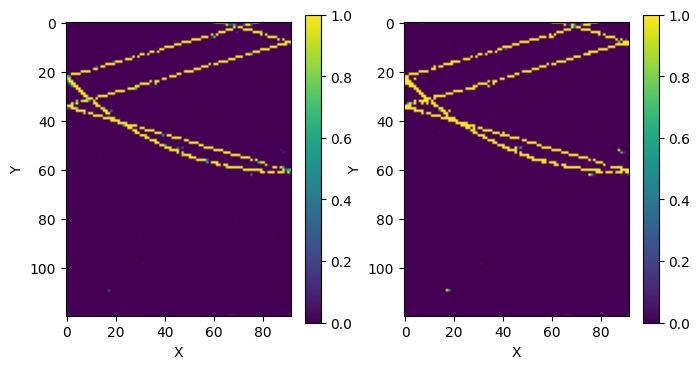

In [77]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
plot2d(pred[0])
ax2 = fig.add_subplot(122)
plot2d(pred[1])

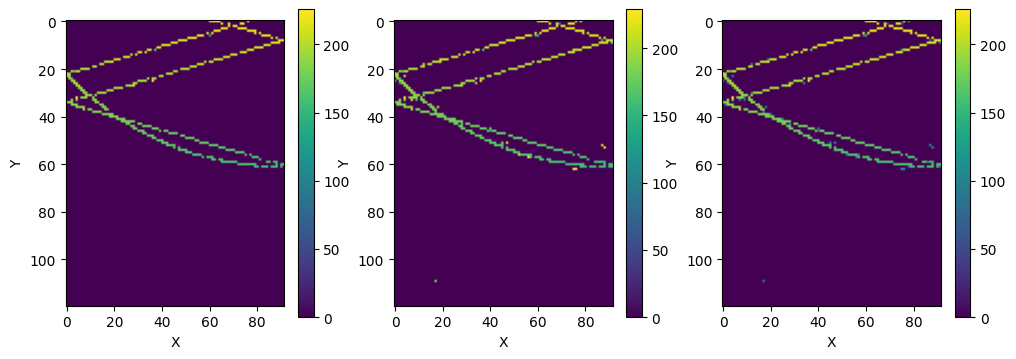

In [78]:
a = (pred[0] > 0.5).float() * test_dataset[0].sn_time
b = (pred[1] > 0.5).float() * test_dataset[0].sn_time
c = (b+a)/2
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(a)
ax2 = fig.add_subplot(132)
plot2d(b)
ax3 = fig.add_subplot(133)
plot2d(c)

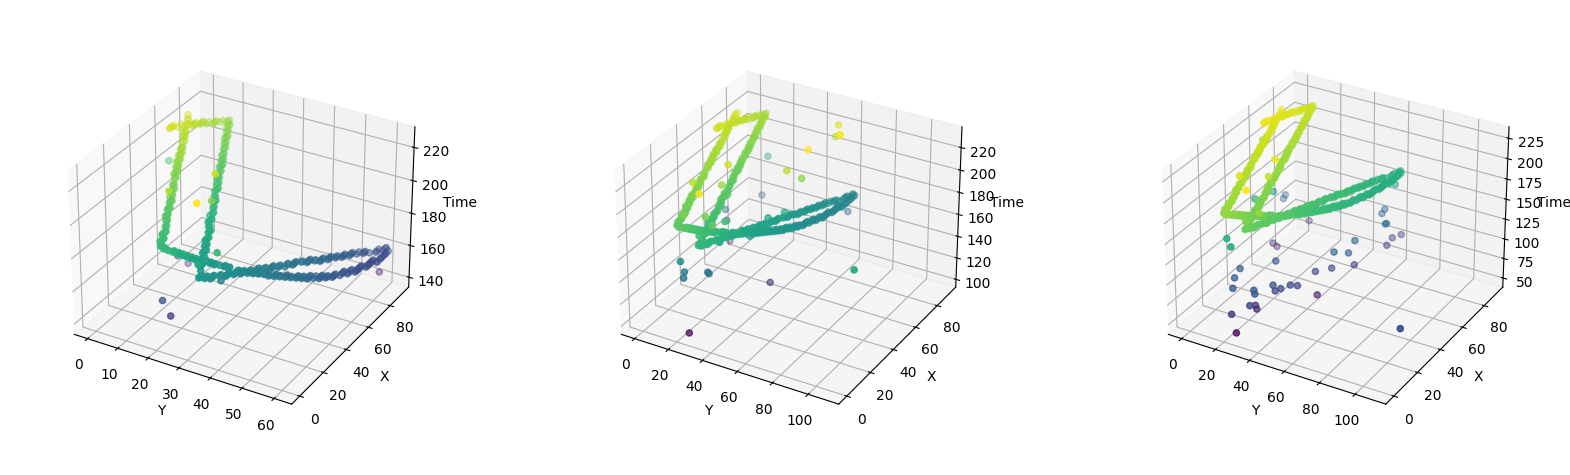

In [79]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(a, ax1)
ax2 = fig.add_subplot(132, projection='3d')
plot3d(b, ax2)
ax3 = fig.add_subplot(133, projection='3d')
plot3d(c, ax3)

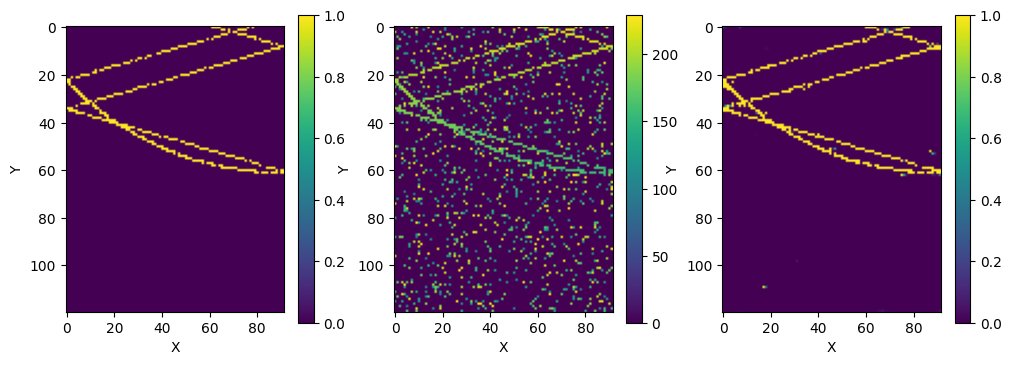

In [80]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(test_dataset[0].signal)
ax2 = fig.add_subplot(132)
plot2d(test_dataset[0].sn_time)
ax3 = fig.add_subplot(133)
plot2d(pred[1])

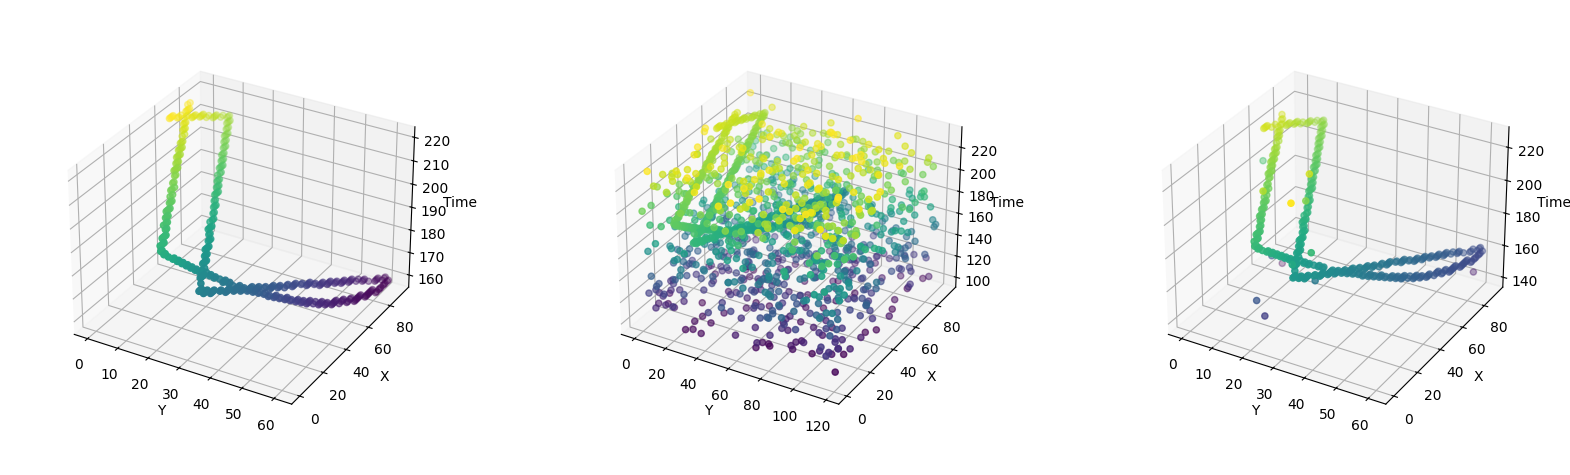

In [81]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(test_dataset[0].signal_time, ax1)
ax2 = fig.add_subplot(132, projection='3d')
plot3d(test_dataset[0].sn_time, ax2)
ax3 = fig.add_subplot(133, projection='3d')
plot3d(a, ax3)

In [97]:
pred_list = [a, b, c]

for i in pred_list:
    mse = calculate_mse_torch(test_dataset[0].signal_time, i)
    psnr = calculate_psnr_torch(test_dataset[0].signal_time, i)
    ssim = calculate_ssim_torch(test_dataset[0].signal_time, i)
    print(f"MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}")

MSE: 91.4735, PSNR: 27.2355, SSIM: 0.9726
MSE: 132.0676, PSNR: 25.6405, SSIM: 0.9597
MSE: 82.4022, PSNR: 27.6891, SSIM: 0.9612


In [71]:
autoencoder.eval()
test_data = torch.tensor(np.stack((a.unsqueeze(0), b.unsqueeze(0)), axis=1))
with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data.to("cpu"))
    pred = pred.squeeze()

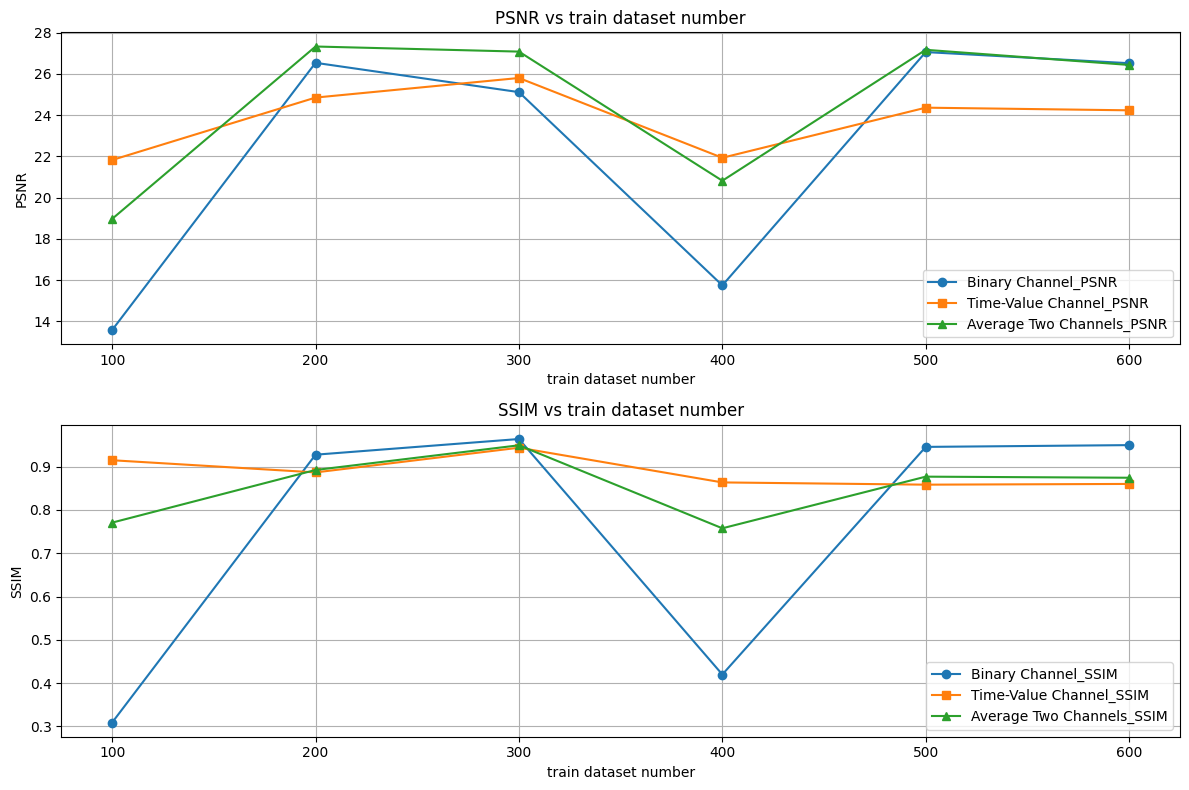

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Data extracted from the image
data = {
    "Input": [100, 200, 300, 400, 500, 600],
    "a_PSNR": [13.5798, 26.5344, 25.1133, 15.7451, 27.0552, 26.5154],
    "a_SSIM": [0.3091, 0.9274, 0.9636, 0.42, 0.9454, 0.9495],
    "b_PSNR": [21.8222, 24.8492, 25.799, 21.9307, 24.36, 24.2315],
    "b_SSIM": [0.9146, 0.8865, 0.9435, 0.8634, 0.8582, 0.8599],
    "c_PSNR": [18.968, 27.3249, 27.0782, 20.8176, 27.1653, 26.4309],
    "c_SSIM": [0.7706, 0.8921, 0.9491, 0.7575, 0.8767, 0.8742],
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 8))

# PSNR plots
plt.subplot(2, 1, 1)
plt.plot(df["Input"], df["a_PSNR"], marker='o', label="Binary Channel_PSNR")
plt.plot(df["Input"], df["b_PSNR"], marker='s', label="Time-Value Channel_PSNR")
plt.plot(df["Input"], df["c_PSNR"], marker='^', label="Average Two Channels_PSNR")
plt.title("PSNR vs train dataset number")
plt.xlabel("train dataset number")
plt.ylabel("PSNR")
plt.legend()
plt.grid(True)

# SSIM plots
plt.subplot(2, 1, 2)
plt.plot(df["Input"], df["a_SSIM"], marker='o', label="Binary Channel_SSIM")
plt.plot(df["Input"], df["b_SSIM"], marker='s', label="Time-Value Channel_SSIM")
plt.plot(df["Input"], df["c_SSIM"], marker='^', label="Average Two Channels_SSIM")
plt.title("SSIM vs train dataset number")
plt.xlabel("train dataset number")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

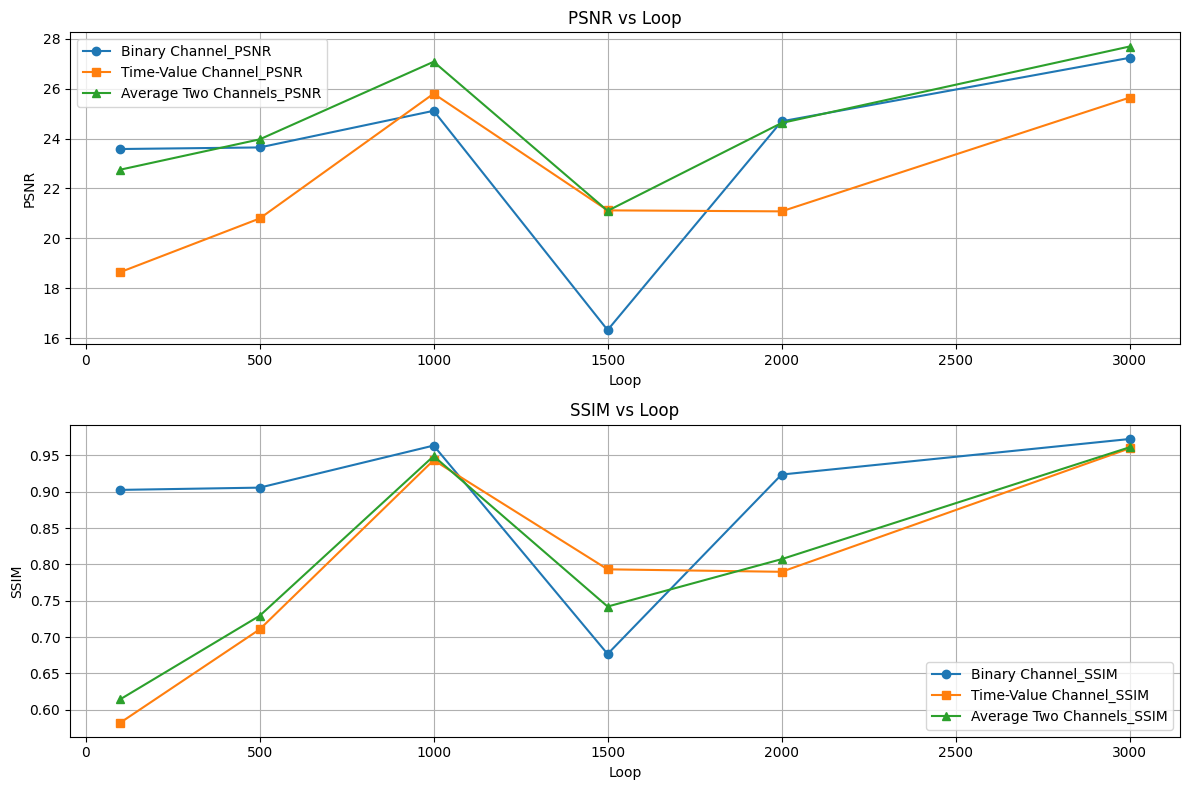

In [45]:
data_new = {
    "Loop": [100, 500, 1000, 1500, 2000, 3000],
    "a_PSNR": [23.5819, 23.6451, 25.1133, 16.3286, 24.6914, 27.2355],
    "a_SSIM": [0.9026, 0.9057, 0.9636, 0.6768, 0.9237, 0.9726],
    "b_PSNR": [18.653, 20.7986, 25.799, 21.1238, 21.0839, 25.6405],
    "b_SSIM": [0.5825, 0.7107, 0.9435, 0.7933, 0.7899, 0.9597],
    "c_PSNR": [22.7561, 23.969, 27.0782, 21.1058, 24.6247, 27.6891],
    "c_SSIM": [0.6147, 0.7294, 0.9491, 0.7421, 0.8073, 0.9612],
}

df_new = pd.DataFrame(data_new)

# Plotting the updated graphs
plt.figure(figsize=(12, 8))

# PSNR plots
plt.subplot(2, 1, 1)
plt.plot(df_new["Loop"], df_new["a_PSNR"], marker='o', label="Binary Channel_PSNR")
plt.plot(df_new["Loop"], df_new["b_PSNR"], marker='s', label="Time-Value Channel_PSNR")
plt.plot(df_new["Loop"], df_new["c_PSNR"], marker='^', label="Average Two Channels_PSNR")
plt.title("PSNR vs Loop")
plt.xlabel("Loop")
plt.ylabel("PSNR")
plt.legend()
plt.grid(True)

# SSIM plots
plt.subplot(2, 1, 2)
plt.plot(df_new["Loop"], df_new["a_SSIM"], marker='o', label="Binary Channel_SSIM")
plt.plot(df_new["Loop"], df_new["b_SSIM"], marker='s', label="Time-Value Channel_SSIM")
plt.plot(df_new["Loop"], df_new["c_SSIM"], marker='^', label="Average Two Channels_SSIM")
plt.title("SSIM vs Loop")
plt.xlabel("Loop")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()